In [1]:
import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, precision_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import display, Markdown, Latex

## seaborn
import seaborn as sns
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

## plotly
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.express as px
# Graphics in retina format 
%config InlineBackend.figure_format = 'retina' 

import warnings
warnings.filterwarnings("ignore")

## The Stock Market Data

In [2]:
Smarket = pd.read_csv('Data/Smarket.csv', index_col=0, parse_dates=True)
Smarket.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
2001-01-01,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
2001-01-01,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


Let's divide this dataset into train and test sets. In doing so, the data before 2005 is considered for the train set and the data from 2005 onward for the test set. That is

In [3]:
X_train, y_train = Smarket.loc[(Smarket.index < '2005'), ['Lag1','Lag2']], Smarket.loc[(Smarket.index < '2005'), ['Direction']]
X_test, y_test = Smarket.loc[(Smarket.index >= '2005'), ['Lag1','Lag2']], Smarket.loc[(Smarket.index >= '2005'), ['Direction']]

## Quadratic Discriminant Analysis

We know that LDA assumes the observations within each class are drawn from a multivariate Gaussian distribution with a class-specific mean vector and a covariance matrix that is common to all $K$ classes.

Similar to LDA, the QDA classifier results from assuming that the
observations from each class are drawn from a Gaussian distribution, and
plugging estimates for the parameters into Bayes’ theorem to perform prediction.

However, there is a major difference between LDA and QDA. LDA assumes the feature **covariance matrices** of classes are the same. This results in a linear decision boundary. On the other hand, QDA is less strict and allows different feature covariance matrices for different classes, which leads to a quadratic decision boundary.

In other words, QDA assumes that each class has its own covariance matrix. QDA assumes that an observation from the $k$th class is of the form $X ∼ N(\mu_k,~\Sigma_k)$, where $\Sigma_k$ is a covariance matrix for the $k$th class. Under this assumption, the Bayes classifier assigns an observation $X = x$ to the class for which

$$\delta_k(x)
=
−\frac{1}{2} \left(x - \mu_k\right)^T
\Sigma_k^{-1} \left(x - \mu_k\right)
−\frac{1}{2}\log\left| \Sigma_k\right|
+ \log \pi_k$$

is the largetst. Thus, the QDA classifier involves plugging estimates for $\Sigma_k$, $\mu_k$, and $\pi_k$ into the above equation.

We can do a Quadratic Discriminant Analysis (QDA) using [**sklearn QDA**](https://scikit-learn.org/0.16/modules/generated/sklearn.qda.QDA.html):

In [4]:
QDA = QuadraticDiscriminantAnalysis()
# Predictions
y_pred = QDA.fit(X_train, y_train).predict(X_test)

* **Prior probabilities of groups:**

In [5]:
Class_Names = list(np.sort(Smarket.Direction.unique()))
PriorProbabilities = pd.DataFrame(QDA.priors_, columns = {'Prior probabilities of groups'}, index = Class_Names)
display(PriorProbabilities.T.round(3))
print('%.2f percent of the training observations correspond to days during which the market went down.' %
        (100*PriorProbabilities.loc['Down'].values[0]))

,Down,Up
Prior probabilities of groups,0.492,0.508


49.20 percent of the training observations correspond to days during which the market went down.


* **Group means:**

These are the average of each predictor within each class, and are used by LDA as estimates of $\mu_k$.

In [6]:
GroupMeans = pd.DataFrame(QDA.means_, columns =X_train.columns, index = Class_Names)
display(GroupMeans.round(4))

,Lag1,Lag2
Down,0.0428,0.0339
Up,-0.0395,-0.0313


* **Classification Report:**

In [7]:
Results = pd.DataFrame(classification_report(y_test, y_pred,
                                             target_names=Class_Names, output_dict=True)).T
display(Results.round(2))

,precision,recall,f1-score,support
Down,0.6,0.27,0.37,111.0
Up,0.6,0.86,0.71,141.0
accuracy,0.6,0.60,0.60,0.6
macro avg,0.6,0.56,0.54,252.0
weighted avg,0.6,0.60,0.56,252.0


* **Confusion Matrix**:

A confusion matrix is a table that is often used to describe the performance of a classification model (classifier) on a set of test data, **X_test** and **y_test**.

Confusion Matrix


,Down,Up
Down,30,81
Up,20,121


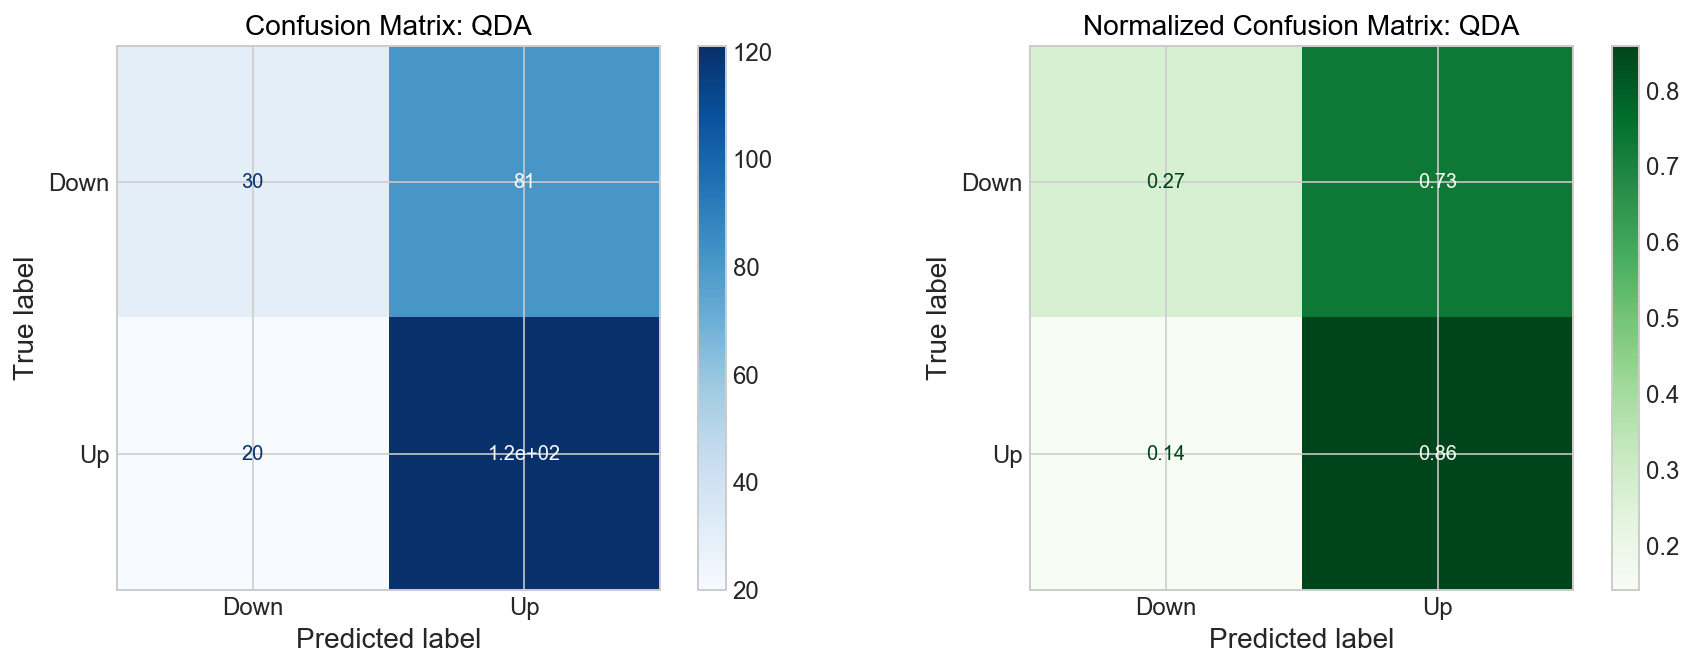

In [8]:
print(Back.CYAN + Fore.BLACK + Style.BRIGHT + 'Confusion Matrix'  + Style.RESET_ALL)
display(pd.DataFrame(data = confusion_matrix(y_test, y_pred), index = Class_Names, columns = Class_Names))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

_ = plot_confusion_matrix(QDA, X_test, y_test, display_labels= Class_Names, cmap= "Blues", normalize= None, ax = ax[0])
_ = ax[0].set_title('Confusion Matrix: QDA')

_ = plot_confusion_matrix(QDA, X_test, y_test, display_labels= Class_Names, cmap= "Greens", normalize= 'true', ax = ax[1])
_ = ax[1].set_title('Normalized Confusion Matrix: QDA')

***